In [1]:
#un canale

In [1]:
from LibraryENGcopia import *
from tqdm import tqdm
import sklearn.preprocessing as ps
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3

In [2]:
#data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
data = h5py.File(complete_string3,'r')

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(5875000, 60)


In [3]:
inizio=0
#len_data=810000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :17]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'46']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(5875000,) (5875000,)


electrode_example = b'47' #Change the name here to change the electrode

prova_rows = range(prova.shape[0])
filt_prova = pd.DataFrame(data = 0, columns=prova.columns, index=prova_rows, dtype = "float32")
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
#ref_df = pd.DataFrame({b'Ref': filt_ref})
for x in tqdm(range(prova.shape[1])):
    filt_prova.values[:,x] = scipy.signal.filtfilt(b, a, prova.values[:,x])
for electrode in prova.columns:
    filt_prova[electrode] = filt_prova[electrode] - filt_ref
#filt_prova = pd.concat([filt_prova, ref_df], axis=1)
time = np.arange(len(prova))
plt.figure(figsize=(10, 6))
plt.plot([x/10000 for x in range (0,prova.shape[0])],prova[electrode_example].values, color='blue',label='Original')
plt.plot([x/10000 for x in range (0,prova.shape[0])],filt_prova[electrode_example].values,color='orange', label='Filtered')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original and Filtered Signals')
plt.legend()
plt.grid(True)
plt.show()

prova=filt_prova
prova

In [4]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
r_prova=prova.reshape(-1, 1)
scaler = StandardScaler()
s_prova = scaler.fit_transform(r_prova)
prova=s_prova
s_prova.shape

(5875000, 1)

# Spike detection

In [5]:
pos, neg=find_all_spikes(prova)

100%|█████████████████████████████▉| 5874694/5874700 [01:04<00:00, 91639.74it/s]

detected spikes: 23325 firing rate:  39.702127659574465


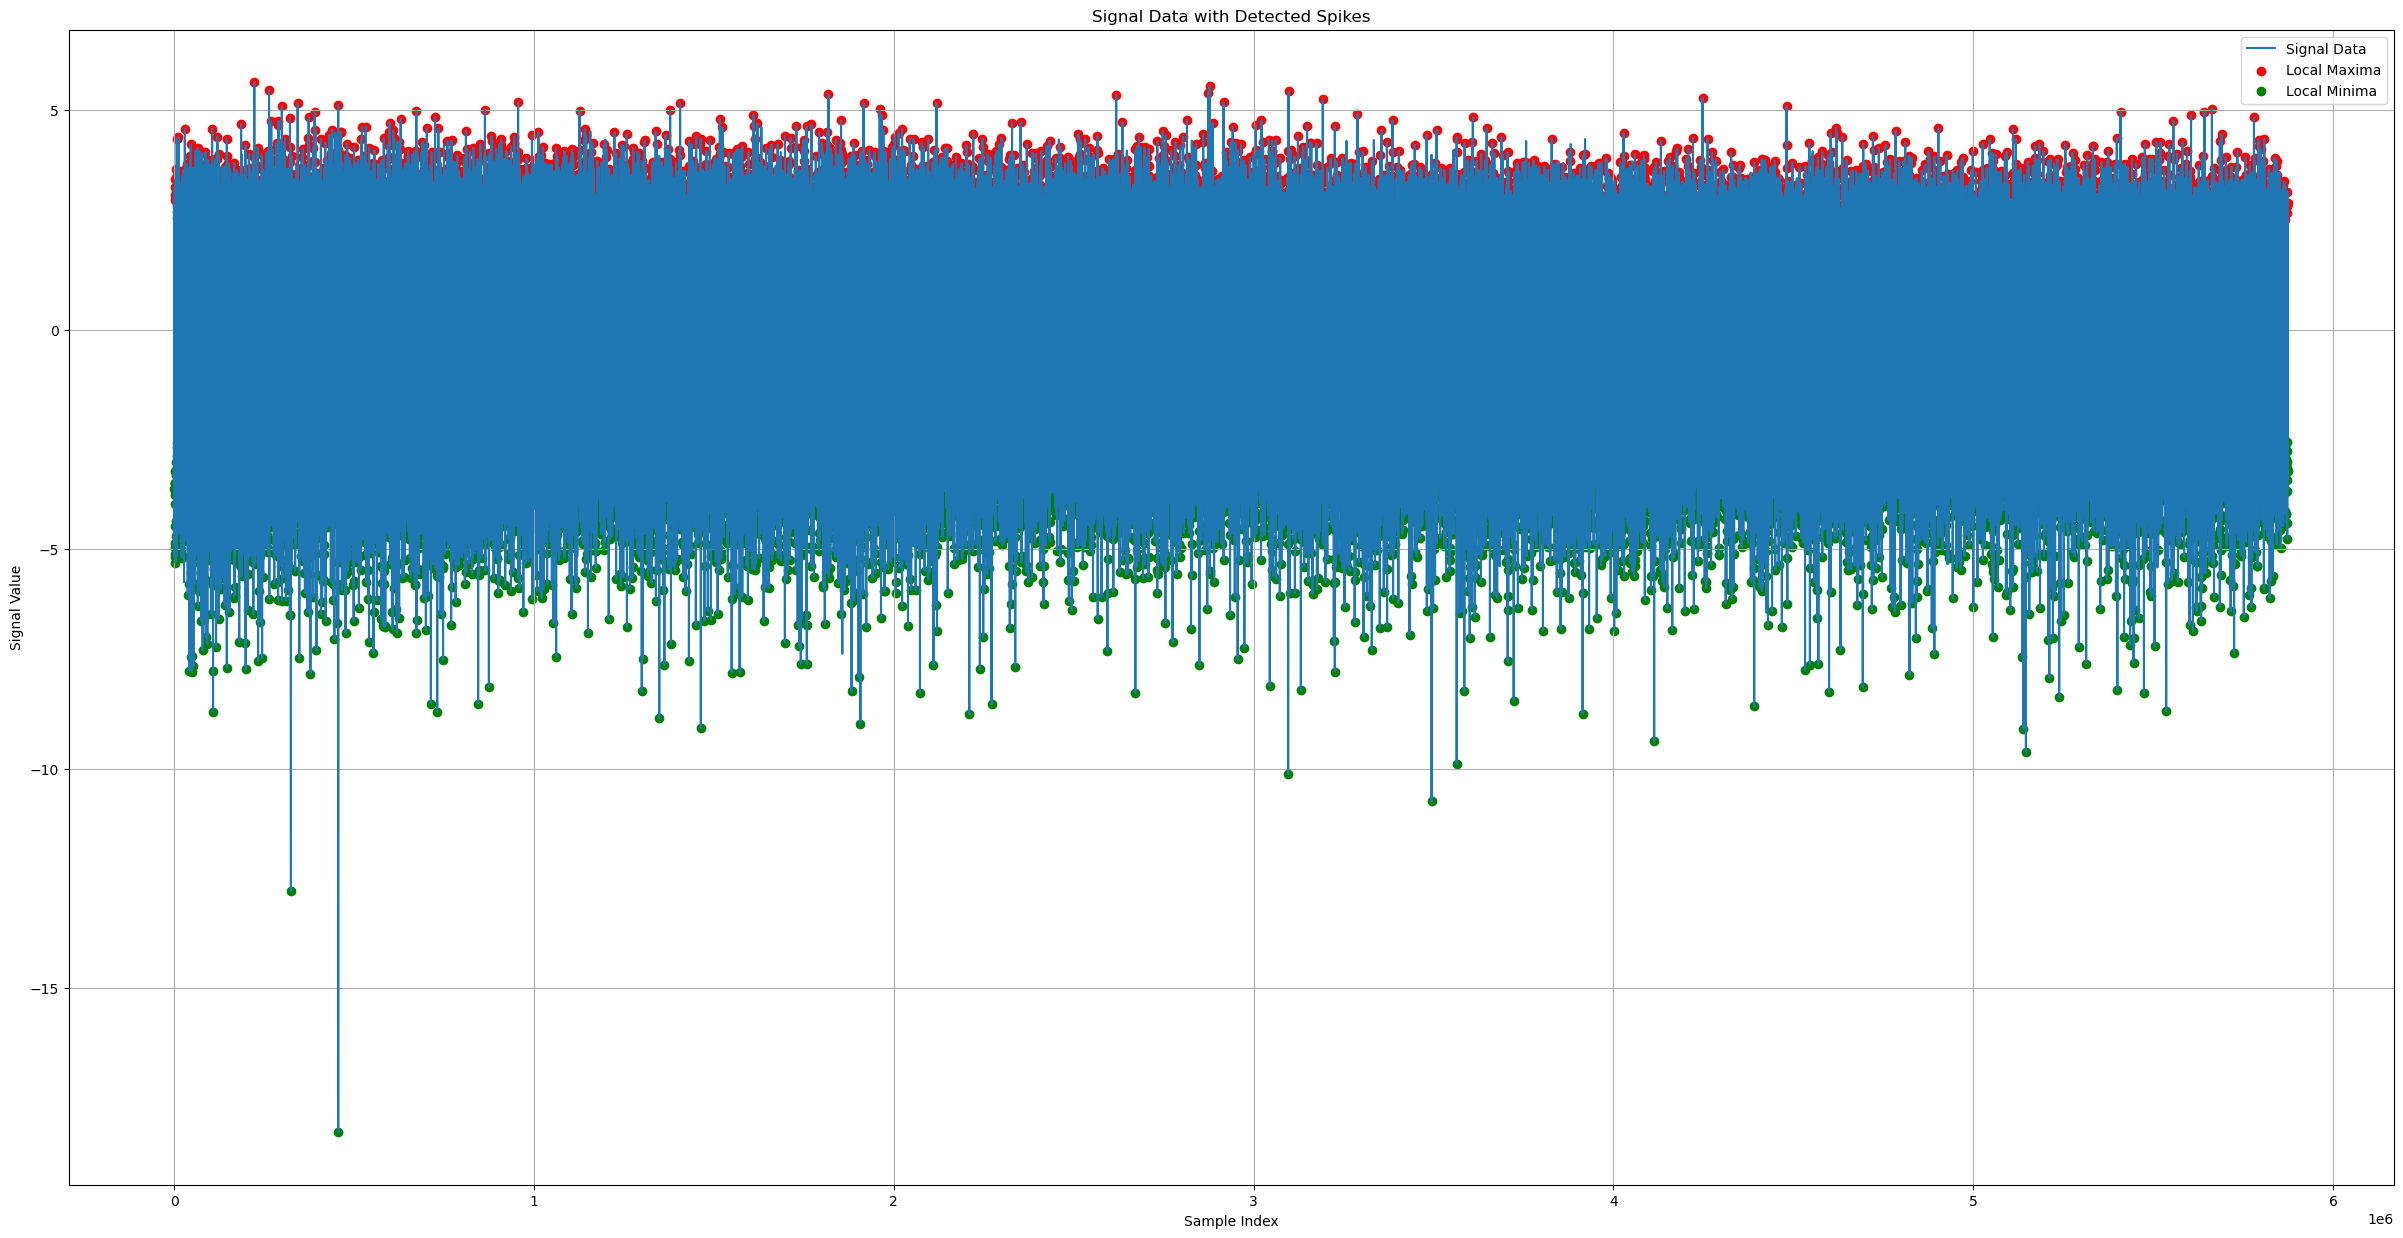

In [6]:
plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(pos, [prova[i] for i in pos], c='red', marker='o', label='Local Maxima')
plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

In [7]:
minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

5874723it [03:11, 30736.91it/s]                                                 

detected spikes: 47999 firing rate:  81.70042553191489
47999


In [28]:
minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

 91%|██████████████████████████▍  | 3387897/3716690 [00:22<00:02, 148154.52it/s]

detected spikes: 10276 firing rate:  27.645951035781543


10276

In [29]:
minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
# segnale KA stimulation: firing rate=8 (spikes 5054)

 83%|████████████████████████▊     | 3079137/3716690 [00:34<00:07, 89888.78it/s]

detected spikes: 9270 firing rate:  24.93946731234867


9270

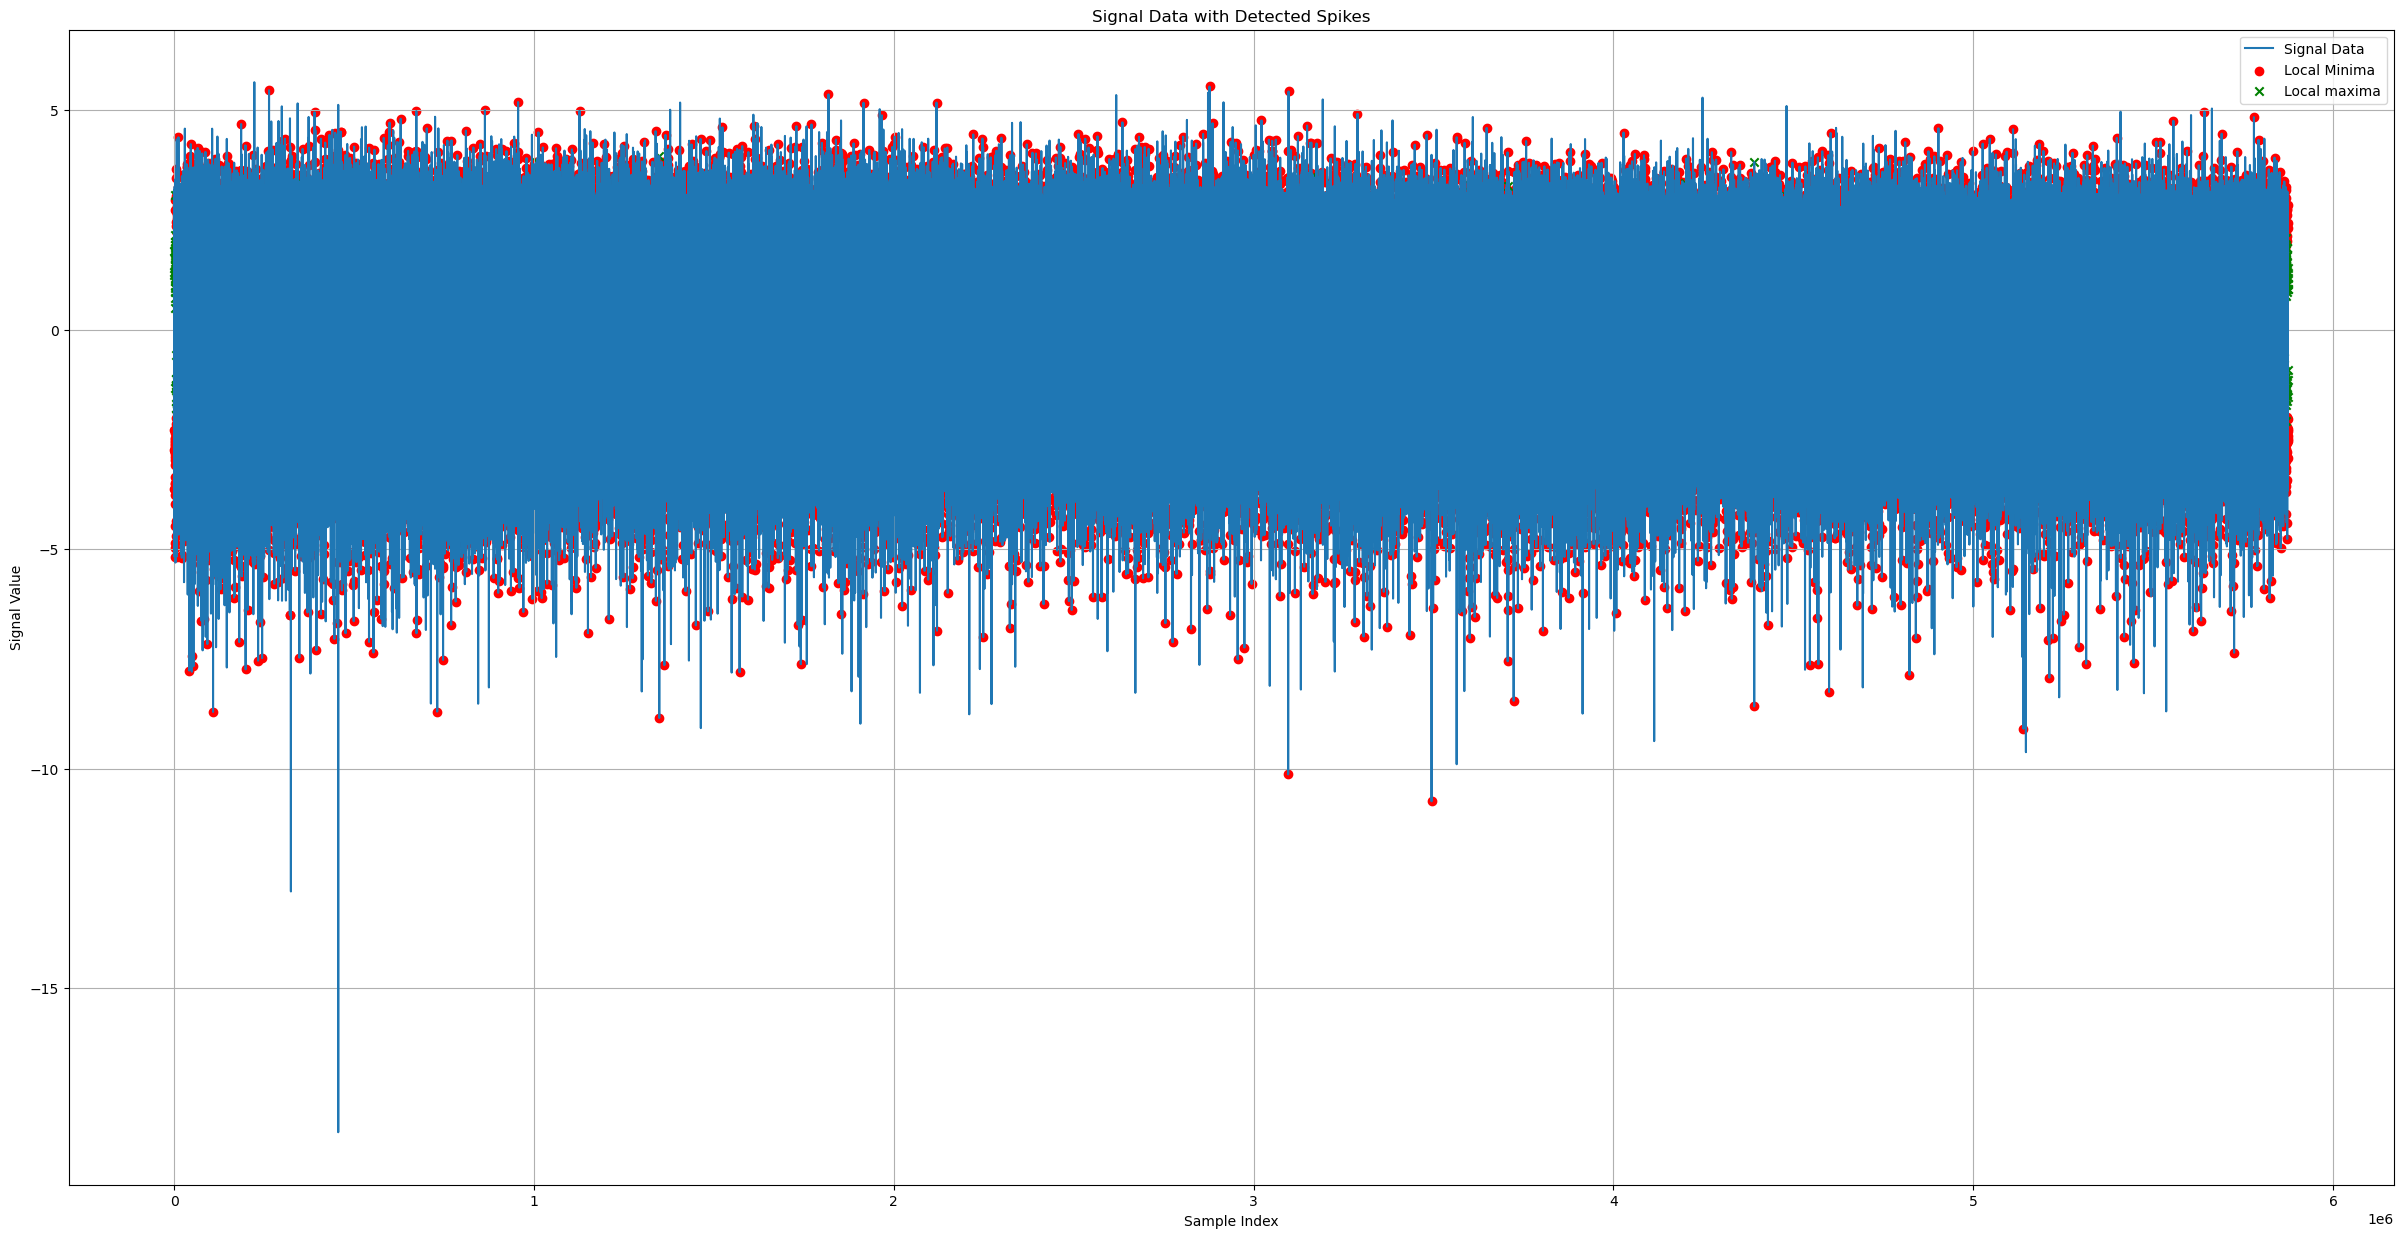

In [8]:
plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

# Cutouts

In [17]:
pre = 0.001
post = 0.002
prima = int(pre*fs)
dopo = int(post*fs)
lunghezza_indici = len(minima) #alligned indices
cutouts = np.empty([lunghezza_indici, prima+dopo])#, np.int32)
dim = prova.shape[0]
k=0
signal_mean=np.mean(prova)
signal_std=scipy.stats.median_abs_deviation(prova)
for i in minima:
    #verifico che la finestra non esca dal segnale
    if (i-prima >= 0) and (i+dopo <= dim):
        spike= s_prova[(int(i)-prima):(int(i)+dopo)].squeeze()
        media=(np.mean(spike))
        std=scipy.stats.median_abs_deviation(spike)
        if std<=3*signal_std:# media<=signal_mean: #and 
            cutouts[k,:] = spike
            k += 1
print(np.isnan(cutouts).sum(),len(cutouts))
#plt.plot(cutouts[4])

0 41246


In [19]:
####rimuovere spike con media superiore a media del segnale e con std superiore a 3 volte std del segnale


In [19]:
prova.shape

(5875000, 1)

mean:  -1.1564823173178714e-19  std:  0.9999999999999999  thresh:  1.9999999999999982  sign mean:  7.130371943005345e-18

66 55377 24


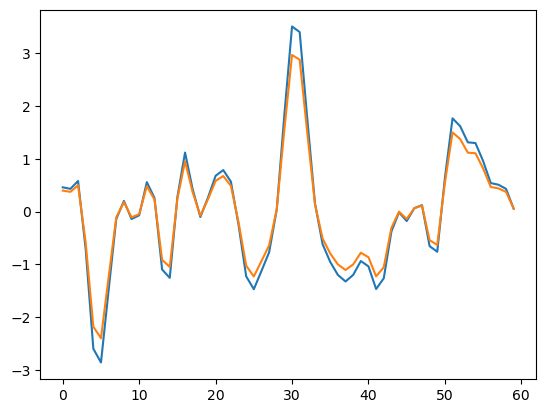

In [82]:
pre = 0.003
post = 0.003
fs=10000
prima = int(pre*fs)
dopo = int(post*fs)
lunghezza_indici = len(pos)
pos_cut= np.empty([lunghezza_indici, prima+dopo])
lunghezza_neg=len(neg)
neg_cut= np.empty([lunghezza_neg, prima+dopo])
dim = prova.shape[0]
#k=0
signal_mean=abs(np.mean(prova))
signal_std=np.std(prova)
sc+=1
i=pos[sc]
#for i in pos:
    #verifico che la finestra non esca dal segnale
if (i-prima >= 0) and (i+dopo <= dim):
    spike= prova[(int(i)-prima):(int(i)+dopo)].squeeze()
    plt.plot(prova[(int(i)-prima):(int(i)+dopo)])
    media=(np.mean(spike))
    std=np.std(spike)
    spike_std=(spike-media)/std
    std2=np.std(spike_std)
    media2=np.mean(spike_std)
    print('mean: ', media2, ' std: ',std2, ' thresh: ', 2*signal_std, ' sign mean: ', 10*signal_mean)
    if abs(std2)<=2*signal_std and abs(media2)<=10*abs(signal_mean):
        print()
        plt.plot(spike_std)
        pos_cut[k,:] = spike_std
        k += 1
        print(sc,i,k)


In [6]:
pos_cut,pos, neg_cut,neg = cut(pos,neg,prova)
print('firing rate: pos:',len(pos)*fs/len_data,'neg: ',len(neg)*fs/len_data)

AttributeError: 'list' object has no attribute 'drop'

In [13]:
#pos_cut=pos_cut[0:1362]
print(pos_cut.shape)
#neg_cut=neg_cut[0:3863]
print(neg_cut.shape)

(1362, 60)
(3863, 60)


3738
before: std 0.0 m 0.0
after: std nan m nan


/var/folders/d6/n7zzsskd0jv11v_qxbdvkkf40000gn/T/ipykernel_21111/1937774745.py:11: RuntimeWarning: invalid value encountered in divide
  img=(img0-mean)/std


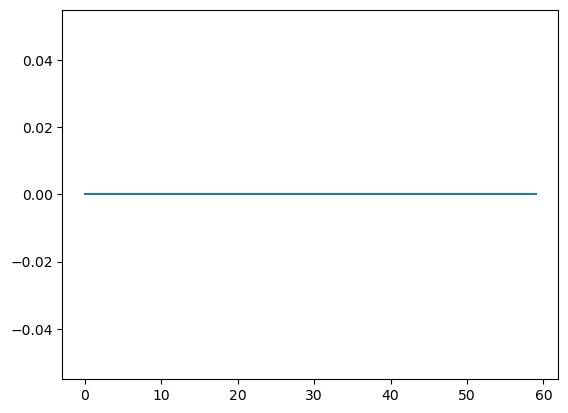

In [18]:
from random import seed
from random import random
from random import randint
x=randint(1,len(pos_cut))
print(x)
img0=pos_cut[x]
std=np.std(img0)
mean=np.mean(img0)
plt.plot(img0)
print('before: std',std,'m',mean)
img=(img0-mean)/std
std=np.std(img)
mean=np.mean(img)
plt.plot(img)
print('after: std',std,'m',mean)
#plt.title('std 1.560')
#plt.savefig('cleannotspike.jpg')
plt.show()

In [19]:
np.mean(np.std(pos_cut))

0.4808327524206036

In [13]:
import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

Explained Variance DataFrame:


,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Explained Variance,0.258278,0.191529,0.119656,0.106423,0.069737,0.057089,0.038862,0.031148,0.024076,0.020753,...,0.000141,0.000023,0.000003,3.165020e-07,2.539276e-08,1.818514e-09,9.675414e-11,4.078808e-12,1.059620e-13,1.392831e-15


In [14]:
cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


Cumulative Explained Variance DataFrame:


,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Cumulative Explained Variance,0.258278,0.449807,0.569463,0.675885,0.745622,0.802711,0.841573,0.872721,0.896797,0.91755,...,0.999974,0.999997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Clustering

Total spikes:  1362
transformed


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For 5 clusters, the silhouette score is: 0.09358935253061781


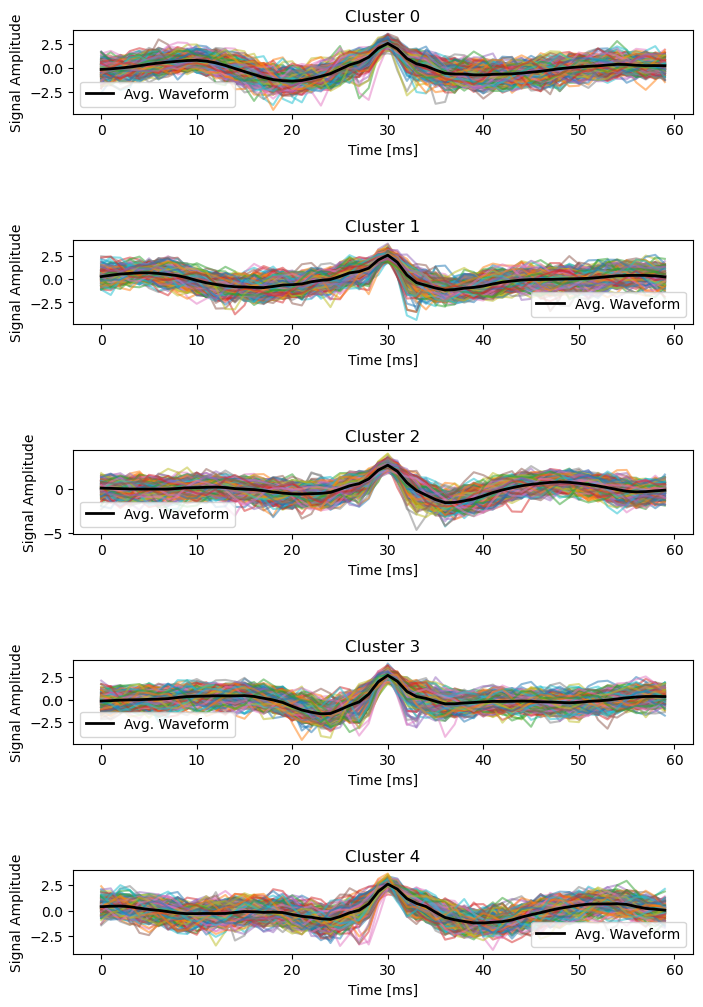

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5891 but corresponding boolean dimension is 1362

In [14]:
final_data_pos= clus(pos_cut,'PCA','kmeans',pos,5,len_data)

Total spikes:  5233
transformed


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For 3 clusters, the silhouette score is: 0.09859927509786011


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


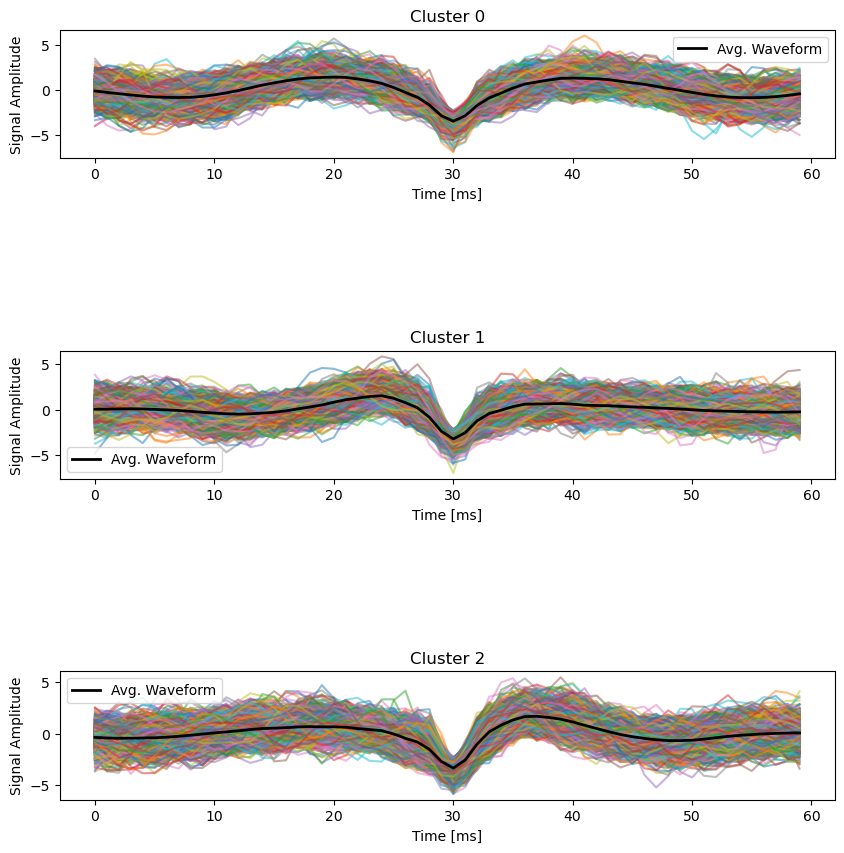

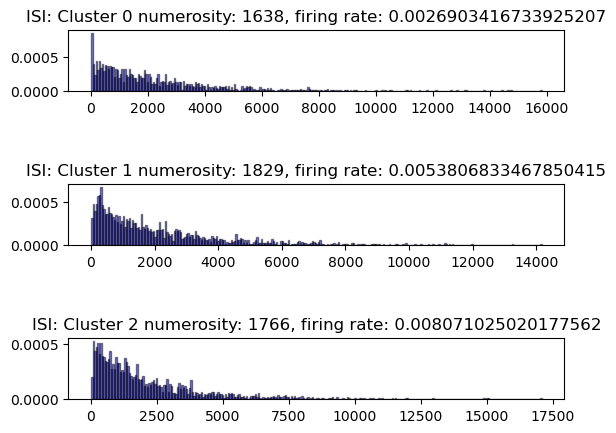

In [21]:
final_data_pos= clus(neg_cut,'PCA','kmeans',neg,3,len_data)

IndexError: index 32 is out of bounds for axis 1 with size 30

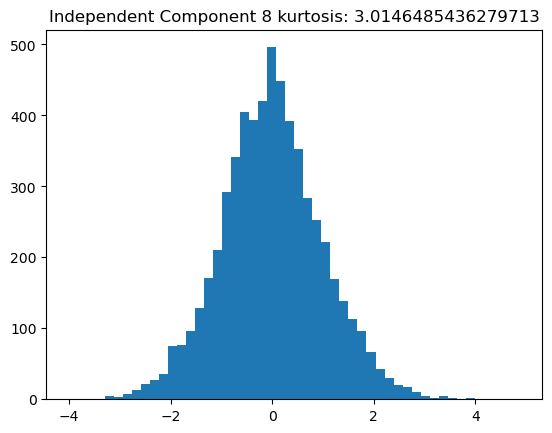

<Figure size 640x480 with 0 Axes>

In [267]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_standardized = scaler.fit_transform(pos_cut)
transformed=[]
ica = FastICA()
ica_components = ica.fit_transform(data_standardized)
from scipy.stats import kurtosis
for i in range(len(ica_components)):
    k= kurtosis(ica_components[i])
    if k >3:
        transformed.append(ica_components[i])
        plt.figure()
        plt.hist(ica_components[:, i], bins=50)
        plt.title(f'Independent Component {i} kurtosis: {k}')

kurtosis_values = kurtosis(ica_components)
print(kurtosis_values)

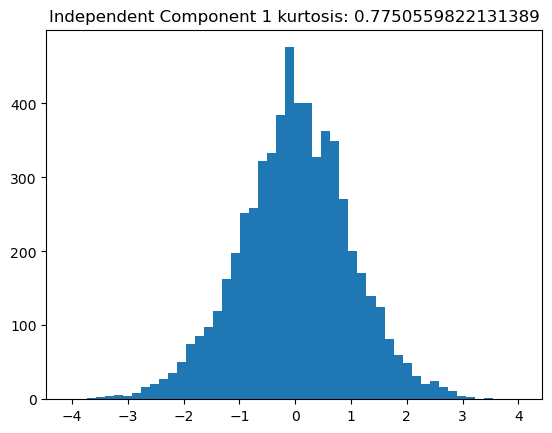

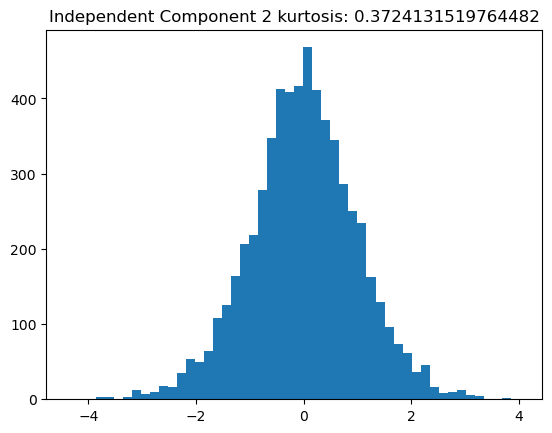

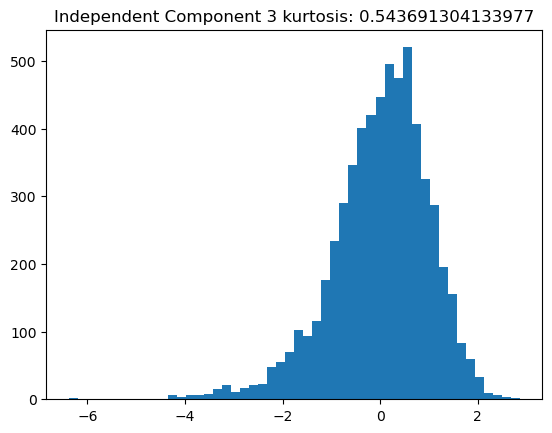

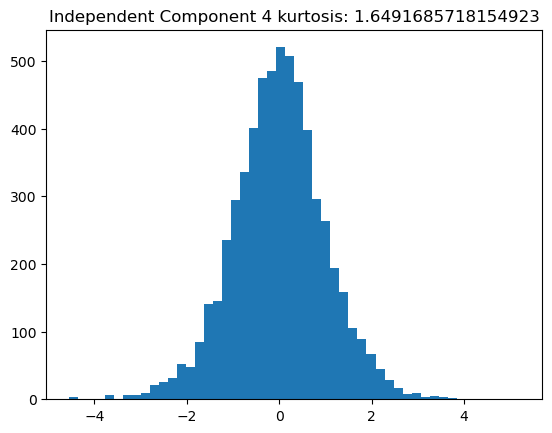

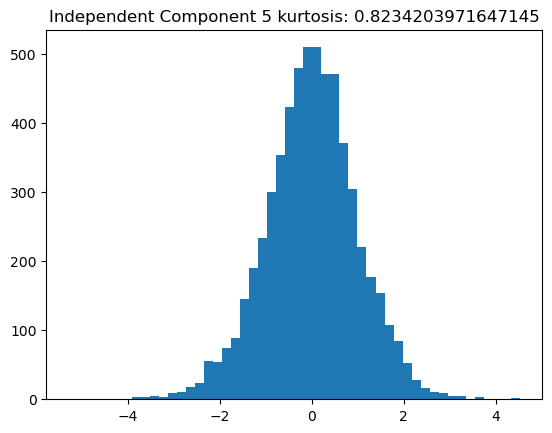

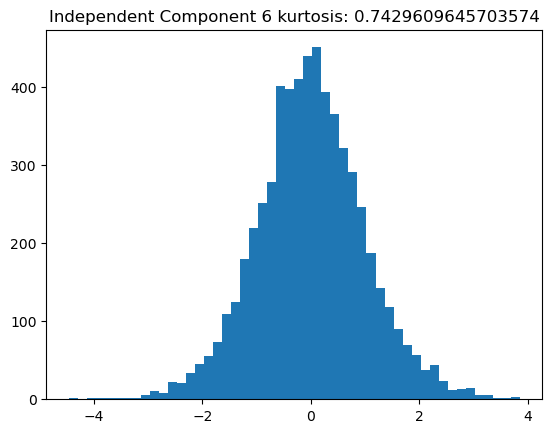

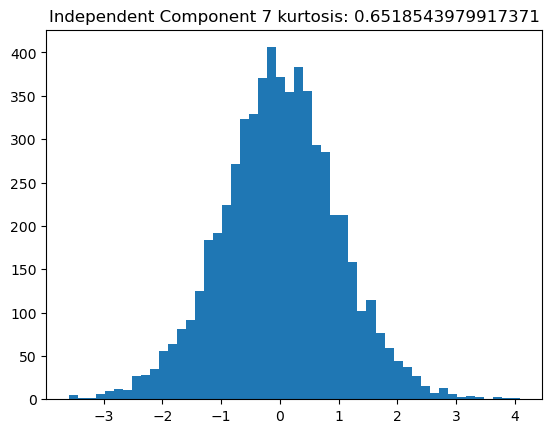

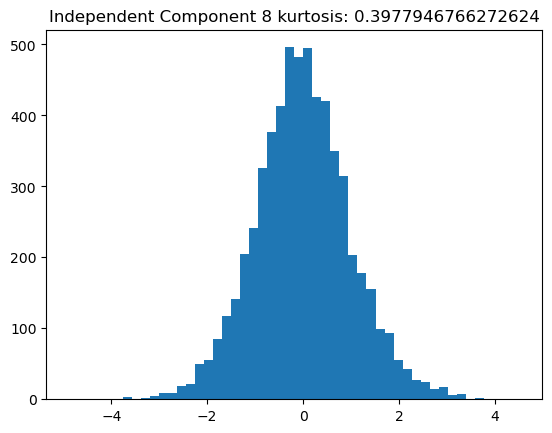

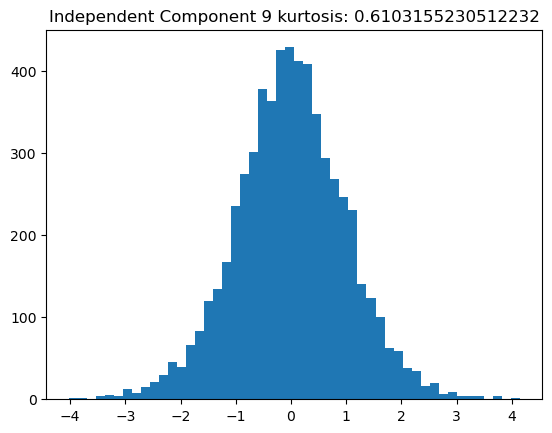

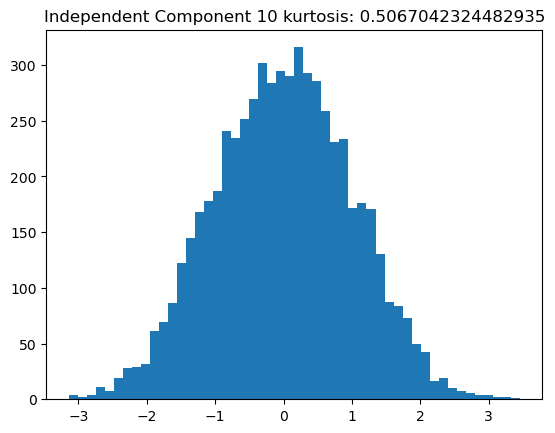

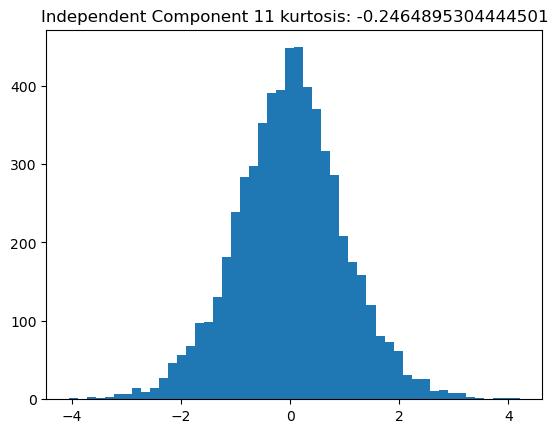

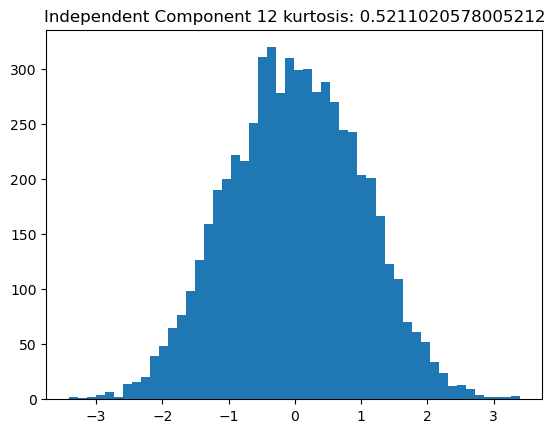

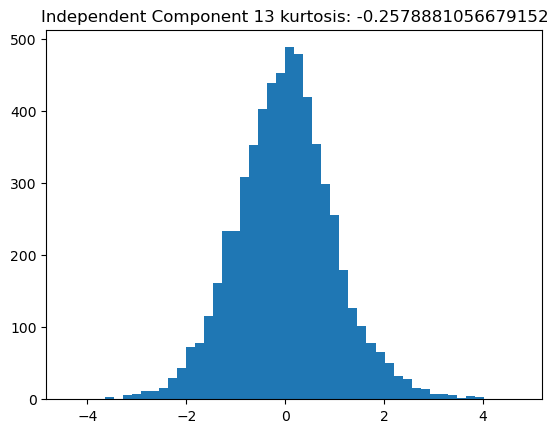

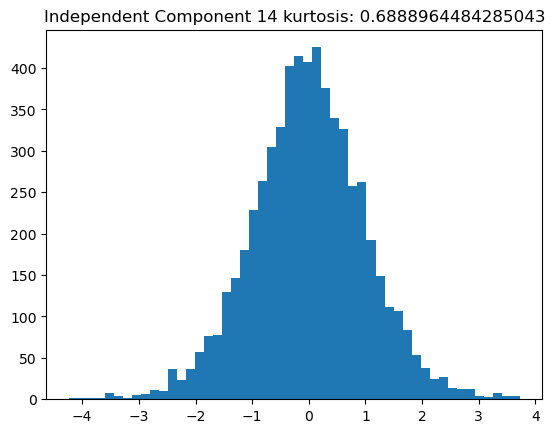

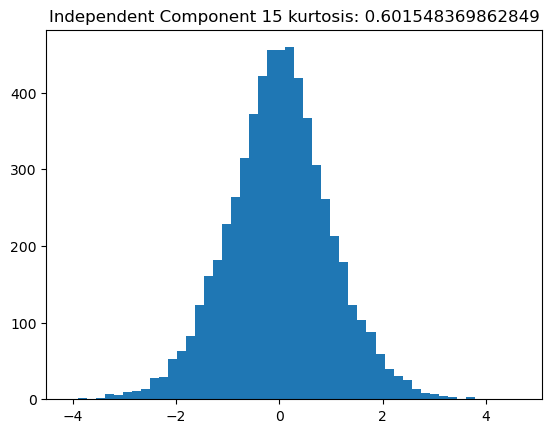

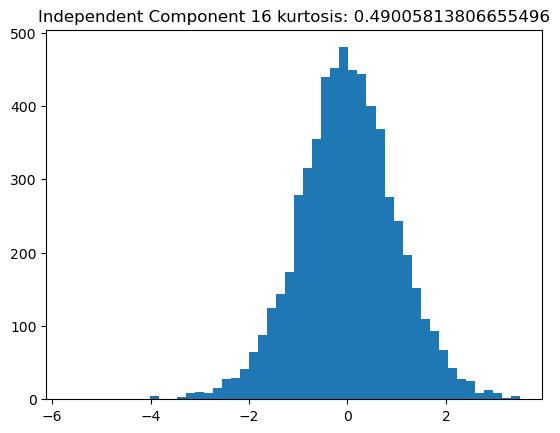

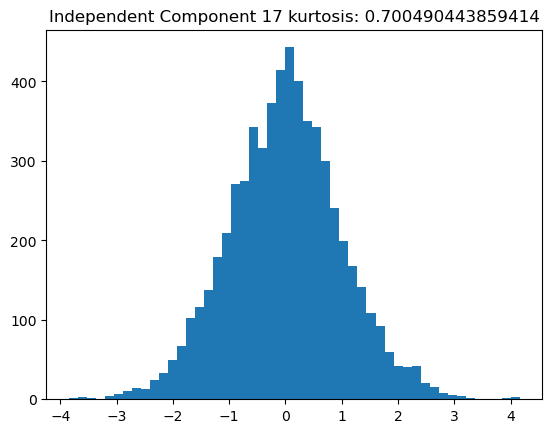

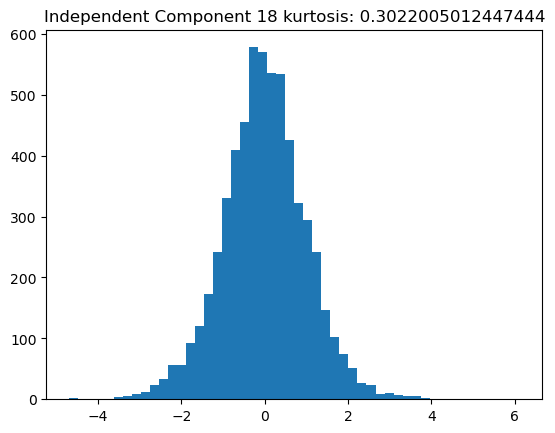

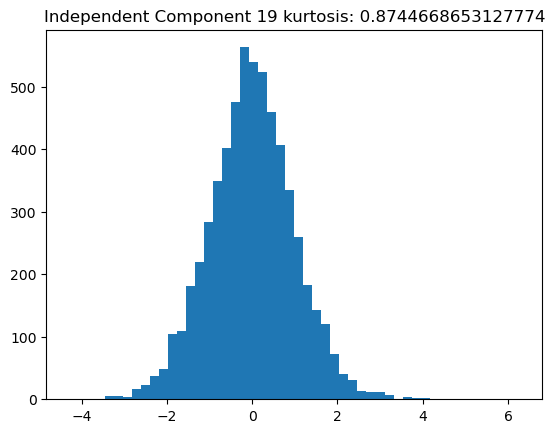

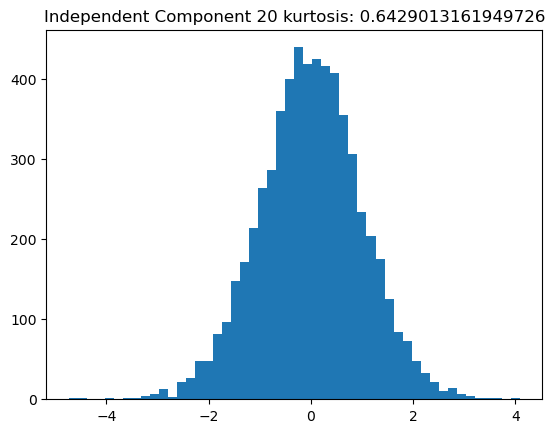

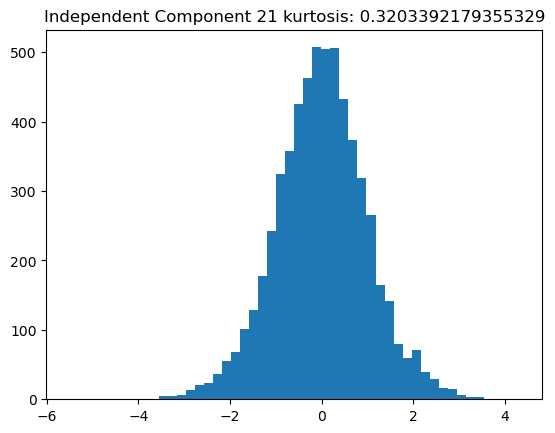

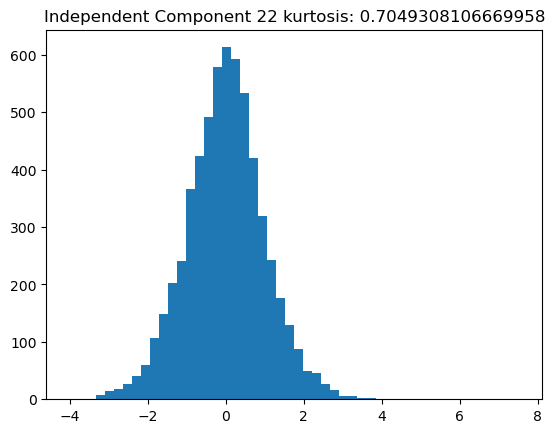

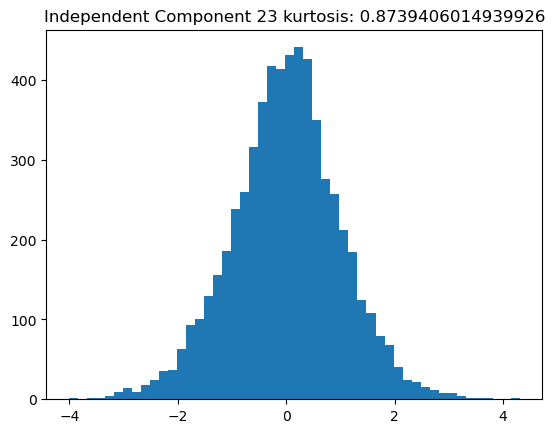

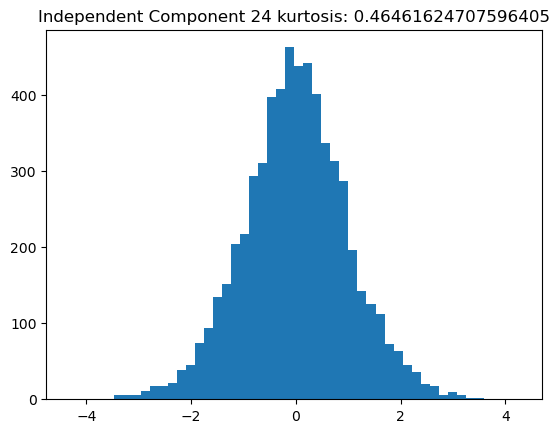

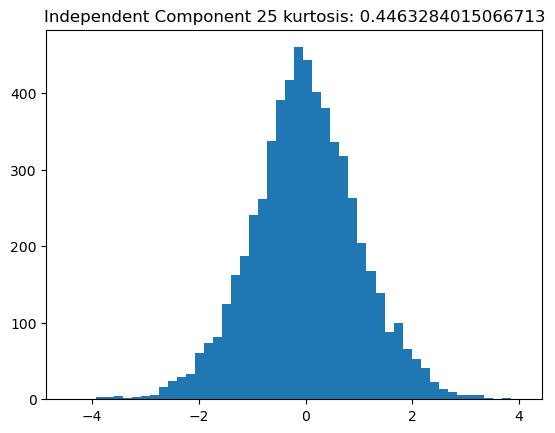

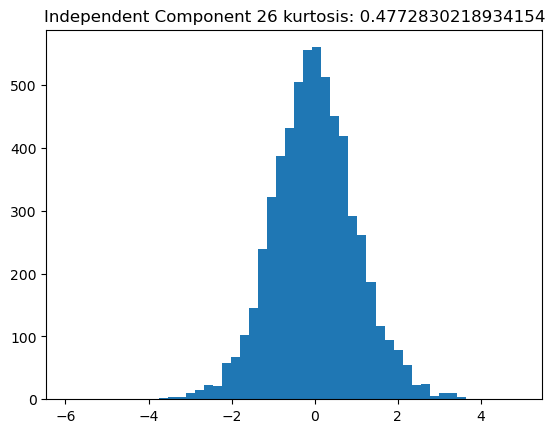

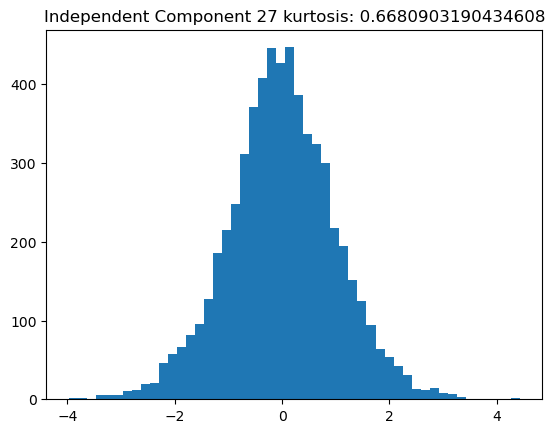

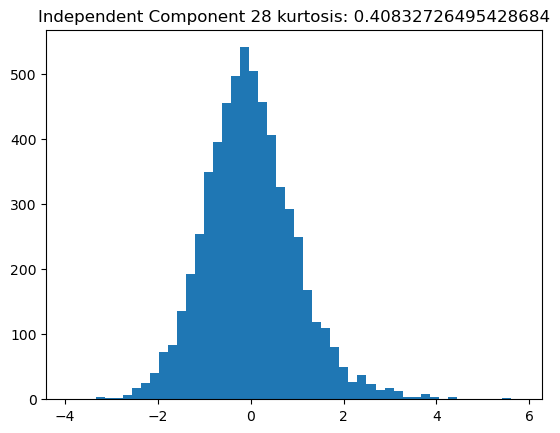

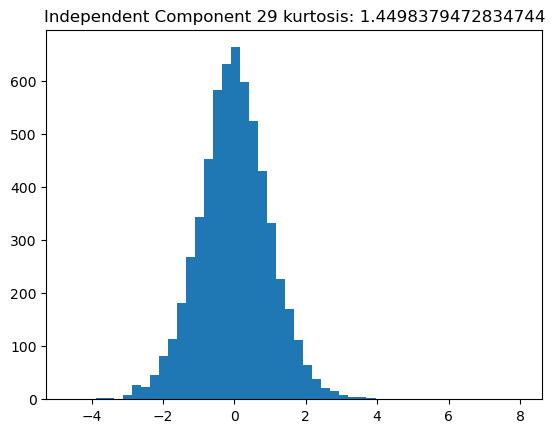

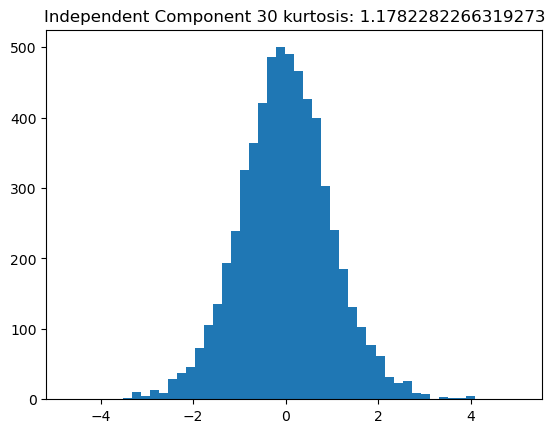

In [115]:
import matplotlib.pyplot as plt

for i in range(ica_components.shape[1]):
    plt.figure()
    plt.hist(ica_components[:, i], bins=50)
    plt.title(f'Independent Component {i + 1} kurtosis: {kurtosis_values[i-1]}')
    plt.show()


In [24]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
ica = FastICA(n_components=40)
ica_components = ica.fit_transform(pos_cut)
kurtosis_values = kurtosis(ica_components)
threshold_kurtosis = 3
selected_components = np.where(kurtosis_values > threshold_kurtosis)[0]
transformed = [ica_components[:, i] for i in selected_components]
for i in selected_components:
    print(f'Selected Independent Component {i + 1}: Kurtosis = {kurtosis_values[i]}')


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:582: UserWarning: n_components is too large: it will be set to 30
  warnings.warn(


Selected Independent Component 4: Kurtosis = 6.206917891724231


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


def clus(cut,analysis,clustering,spike_list,n,len_data):
    from sklearn.cluster import KMeans
    from sklearn.decomposition import FastICA
    from scipy.stats import kurtosis
    import numpy as np
    if analysis=='PCA':        
        scale = StandardScaler()
        estratti_norm = scale.fit_transform(cut)
        print('Total spikes: ', estratti_norm.shape[0])
        n_comp=10
        pca = PCA(n_components=n_comp)
        transformed = pca.fit_transform(estratti_norm)
        print('transformed')
        #transformed=cut
    else:
        if analysis=='ICA':
            ica = FastICA(n_components=40)
            ica_components = ica.fit_transform(cut)
            kurtosis_values = kurtosis(ica_components)
            threshold_kurtosis = 3
            selected_components = np.where(kurtosis_values > threshold_kurtosis)[0]
            transformed = [ica_components[:, i] for i in selected_components]
            for i in selected_components:
                print(f'Selected Independent Component {i + 1}: Kurtosis = {kurtosis_values[i]}')

    if clustering=='kmeans':
        num_clusters = n
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(transformed)
        labels = kmeans.labels_
    else:
        if clustering=='dbscan':
            dbscan = DBSCAN(eps=1.5, min_samples=60)
            labels = dbscan.fit_predict(transformed)


    final_data=[]
    unique_labels = np.unique(labels)
    
    if len(unique_labels) == 1:
        print("DBSCAN assigned only one cluster.")
    else:
        silhouette_avg = silhouette_score(transformed, labels)
        num_clusters = len(np.unique(labels[labels != -1]))
        print("For", num_clusters,"clusters, the silhouette score is:", silhouette_avg)

    fig = plt.figure(figsize=(6, 8))

    # Iterate over unique cluster labels
    for i, cluster_label in enumerate(unique_labels):
        # Extract data points for the current cluster
        cluster_data = cut[labels == cluster_label]
        #final_data.append(spike_list[labels == cluster_label].tolist())

        # Plot the individual cluster data
        plt.subplot(len(unique_labels), 1, i + 1)
        plt.plot(cluster_data.transpose(), alpha=0.5)  # Use alpha for transparency
        #print(cluster_data)
        plt.title(f'Cluster {cluster_label}')
        plt.xlabel('Time [ms]')
        plt.ylabel('Signal Amplitude')

        # Plot the average waveform
        mean_wave = np.mean(cluster_data, axis=0)
        std_wave = np.std(cluster_data, axis=0)
        plt.plot(mean_wave, color='black', linewidth=2, label='Avg. Waveform')
        plt.legend()

    # Adjust layout to prevent overlapping
    #plt.tight_layout()
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    spike_list=np.array(spike_list)
    for i in unique_labels:
        ul=spike_list[labels==i]
        final_data.append(ul)
        plt.subplot(len(unique_labels), 1, i + 1)
        plt.hist(np.diff(ul), bins=300, density=True, alpha=0.5, color='blue', edgecolor='black')
        plt.title(f'ISI: Cluster {i} numerosity: {len(final_data[i])}')
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return final_data, unique_labels

Total spikes:  5830
transformed


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


For 3 clusters, the silhouette score is: 0.22540335940441125




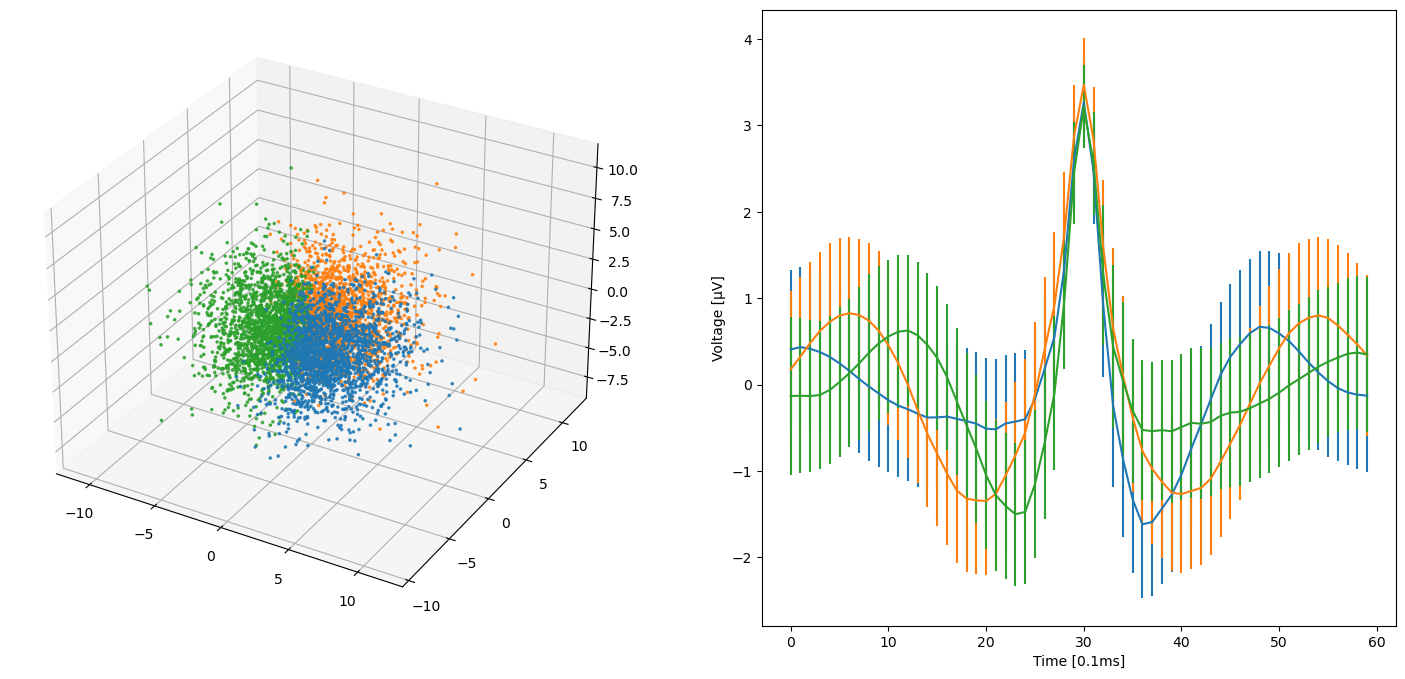

Trans shape:  (5830, 3)
Spike list:  5830


/Users/Gaia_1/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


In [19]:
clustering='kmeans'
#clustering='gaussianmixture'
#clustering='gerarchico'
n=3
pos_list=various_clustering(clustering,n,pos_cut,pos,fs,n_comp=3,centroids=False)


Spike detected as noise 2155
cluster_labels [ 0  1  0 ... -1  0 -1]
removing
20223

Number of clusters:  2 
The silhouette score is: 0.4238330775683062

Blue spikes: 9713

Orange spikes: 8356


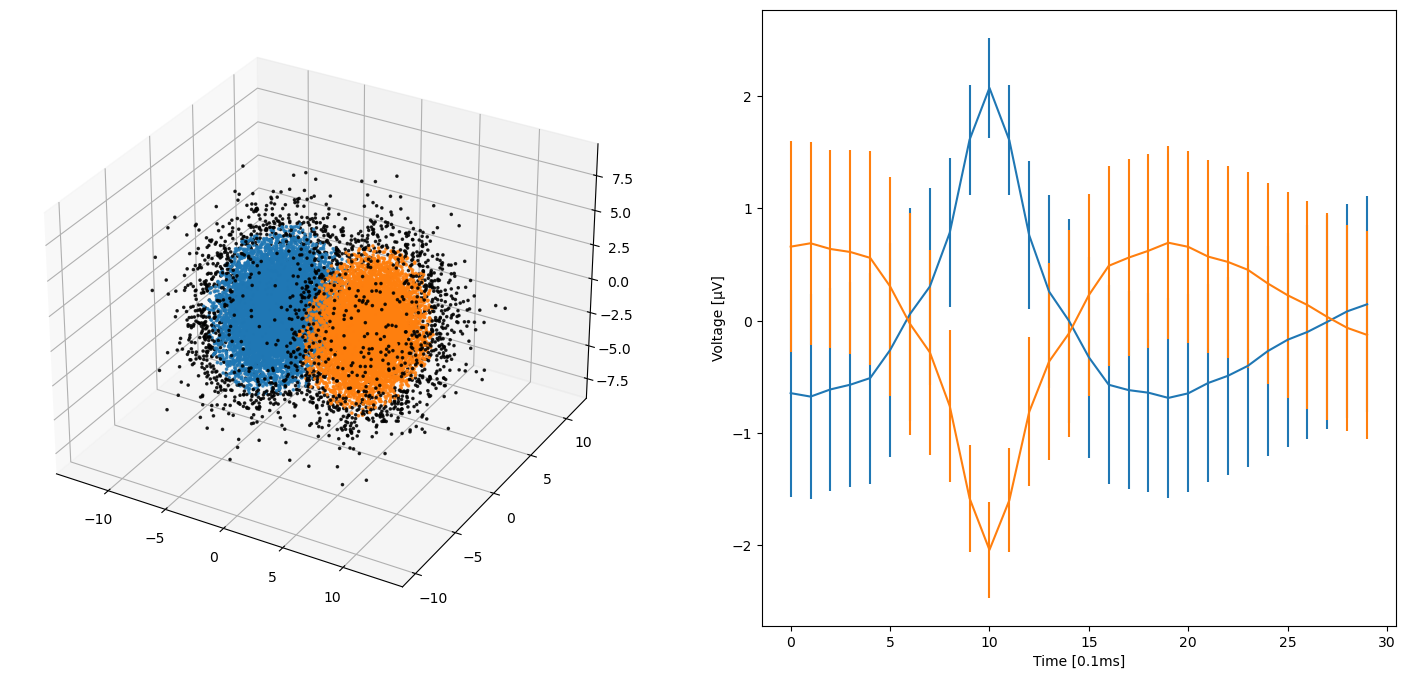

In [43]:
spike_list=minima_pos
pca = PCA(n_components=3)
pos_transformed = pca.fit_transform(pos_cutouts)
model = DBSCAN(eps=1.1, min_samples=60, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
cluster_labels = model.fit_predict(pos_transformed)
final_list_dbscan=funzionedscan(pos_cutouts,pos_transformed,cluster_labels,minima_pos)